In [4]:
import os
import gc
import traceback
import numpy as np
import pandas as pd
import seaborn as sns
import datatable as dt
import gresearch_crypto
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, mean_absolute_error
data_path = '../input/g-research-crypto-forecasting/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.core.common.SettingWithCopyWarning)
    
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [14, 8]  # width, height

In [5]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.utils.validation import _deprecate_positional_args
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name

        if col_type not in ['object', 'category', 'datetime64[ns, UTC]', 'datetime64[ns]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [7]:
import datatable as dt
extra_data_files = {0: '../input/cryptocurrency-extra-data-binance-coin', 2: '../input/cryptocurrency-extra-data-bitcoin-cash', 1: '../input/cryptocurrency-extra-data-bitcoin', 3: '../input/cryptocurrency-extra-data-cardano', 4: '../input/cryptocurrency-extra-data-dogecoin', 5: '../input/cryptocurrency-extra-data-eos-io', 6: '../input/cryptocurrency-extra-data-ethereum', 7: '../input/cryptocurrency-extra-data-ethereum-classic', 8: '../input/cryptocurrency-extra-data-iota', 9: '../input/cryptocurrency-extra-data-litecoin', 11: '../input/cryptocurrency-extra-data-monero', 10: '../input/cryptocurrency-extra-data-maker', 12: '../input/cryptocurrency-extra-data-stellar', 13: '../input/cryptocurrency-extra-data-tron'}

# Uncomment to load the original csv [slower]
# orig_df_train = pd.read_csv(data_path + 'train.csv') 
# supp_df_train = pd.read_csv(data_path + 'supplemental_train.csv')
# df_asset_details = pd.read_csv(data_path  + 'asset_details.csv').sort_values("Asset_ID")

orig_df_train = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_train.jay').to_pandas()
df_asset_details = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_asset_details.jay').to_pandas()
supp_df_train = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_supplemental_train.jay').to_pandas()
assets_details = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_asset_details.jay').to_pandas()
asset_weight_dict = {assets_details['Asset_ID'].tolist()[idx]: assets_details['Weight'].tolist()[idx] for idx in range(len(assets_details))}
asset_name_dict = {assets_details['Asset_ID'].tolist()[idx]: assets_details['Asset_Name'].tolist()[idx] for idx in range(len(assets_details))}

def load_training_data_for_asset(asset_id, load_jay = True):
    dfs = []
    if INCCOMP: dfs.append(orig_df_train[orig_df_train["Asset_ID"] == asset_id].copy())
    if INCSUPP: dfs.append(supp_df_train[supp_df_train["Asset_ID"] == asset_id].copy())
    
    if load_jay:
        if INC2017 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.jay').to_pandas())
        if INC2018 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.jay').to_pandas())
        if INC2019 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.jay').to_pandas())
        if INC2020 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.jay').to_pandas())
        if INC2021 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.csv'): dfs.append(dt.fread(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.jay').to_pandas())
    else: 
        if INC2017 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2017) + '.csv'))
        if INC2018 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2018) + '.csv'))
        if INC2019 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2019) + '.csv'))
        if INC2020 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2020) + '.csv'))
        if INC2021 and os.path.exists(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.csv'): dfs.append(pd.read_csv(extra_data_files[asset_id] + '/full_data__' + str(asset_id) + '__' + str(2021) + '.csv'))
    df = pd.concat(dfs, axis = 0) if len(dfs) > 1 else dfs[0]
    df['date'] = pd.to_datetime(df['timestamp'], unit = 's')
    if LOAD_STRICT: df = df.loc[df['date'] < "2021-06-13 00:00:00"]    
    df = df.sort_values('date')
    return df

def load_data_for_all_assets():
    dfs = []
    for asset_id in list(extra_data_files.keys()): dfs.append(load_training_data_for_asset(asset_id))
    return pd.concat(dfs)

In [8]:
DEVICE = 'CPU'

# CV PARAMS
FOLDS = 5
GROUP_GAP = 130
MAX_TEST_GROUP_SIZE = 180
MAX_TRAIN_GROUP_SIZE = 280

# LOAD STRICT? YES=1 NO=0 | see: https://www.kaggle.com/julian3833/proposal-for-a-meaningful-lb-strict-lgbm
LOAD_STRICT = True

# WHICH YEARS TO INCLUDE? YES=1 NO=0
INC2021 = 0
INC2020 = 0
INC2019 = 0
INC2018 = 0
INC2017 = 0
INCCOMP = 1
INCSUPP = 0

train_data = load_data_for_all_assets()
test = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_example_test.jay').to_pandas()
sample_prediction_df = dt.fread('../input/cryptocurrency-extra-data-binance-coin/orig_example_sample_submission.jay').to_pandas()
print("Loaded all data!")

Loaded all data!


In [9]:
# Two features from the competition tutorial
def upper_shadow(df): return df['High'] - np.maximum(df['Close'], df['Open'])
def lower_shadow(df): return np.minimum(df['Close'], df['Open']) - df['Low']

# A utility function to build features from the original df
def get_features(df):
    df_feat = df[['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']].copy()
    df_feat['upper_Shadow'] = upper_shadow(df_feat)
    df_feat['lower_Shadow'] = lower_shadow(df_feat)
    df_feat["high_div_low"] = df_feat["High"] / df_feat["Low"]
    df_feat["open_sub_close"] = df_feat["Open"] - df_feat["Close"]
    return df_feat

In [10]:
def fill_nan_inf(df):
    df = df.fillna(0)
    df = df.replace([np.inf, -np.inf], 0)
    return df

train_data['date'] = pd.to_datetime(train_data['timestamp'], unit = 's')
train_data = train_data.sort_values('date')
groups = pd.factorize(train_data['date'].dt.day.astype(str) + '_' + train_data['date'].dt.month.astype(str) + '_' + train_data['date'].dt.year.astype(str))[0]
dates = train_data['date'].copy()
target = train_data['Target'].copy()
timestamp = train_data['timestamp'].copy()
train_data.drop(columns = 'Target', inplace = True)
train_data = reduce_mem_usage(train_data)
assets_idx = train_data['Asset_ID']
train_data = get_features(train_data)
train_data['Asset_ID'] = assets_idx
train_data['groups'] = groups
train_data['date'] = dates
train_data = reduce_mem_usage(train_data)
train_data['Target'] = target
train_data['timestamp'] = timestamp
train_data['Weight'] = train_data['Asset_ID'].map(asset_weight_dict)

train_data = fill_nan_inf(train_data)
test = fill_nan_inf(test)

feature_names = [i for i in train_data.columns if i not in ['Target', 'date', 'timestamp', 'VWAP', 'Asset_ID', 'groups', 'Weight']]

Memory usage of dataframe is 1864.92 MB
Memory usage after optimization is: 974.84 MB
Decreased by 47.7%
Memory usage of dataframe is 1229.15 MB
Memory usage after optimization is: 1102.00 MB
Decreased by 10.3%


In [11]:
from lightgbm import LGBMRegressor
import optuna

y_labels = train_data['Target'].values
X_train = train_data[feature_names].values
weights = train_data['Weight'].values
groups = train_data['groups'].values

<AxesSubplot:title={'center':'PurgedGroupTimeSeriesSplit'}, xlabel='Sample index', ylabel='CV iteration'>

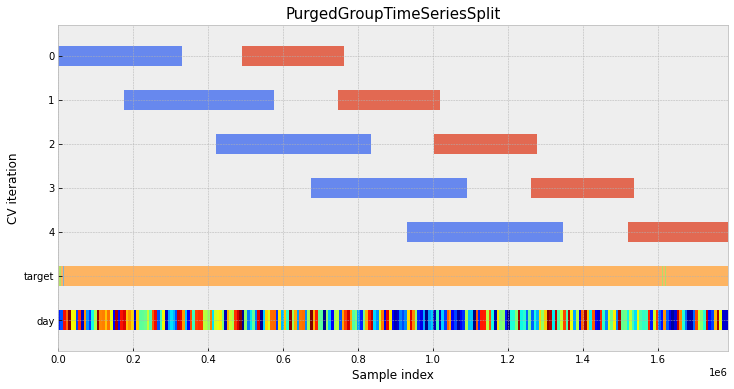

In [12]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=10):
    cmap_cv = plt.cm.coolwarm
    jet = plt.cm.get_cmap('jet', 256)
    seq = np.linspace(0, 1, 256)
    _ = np.random.shuffle(seq)   # inplace
    cmap_data = ListedColormap(jet(seq))    
    for ii, (tr, tt) in enumerate(list(cv.split(X=X, y=y, groups=group))):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0        
        ax.scatter(range(len(indices)), [ii + .5] * len(indices), c=indices, marker='_', lw=lw, cmap=cmap_cv, vmin=-.2, vmax=1.2)
    ax.scatter(range(len(X)), [ii + 1.5] * len(X), c=y, marker='_', lw=lw, cmap=plt.cm.Set3)
    ax.scatter(range(len(X)), [ii + 2.5] * len(X), c=group, marker='_', lw=lw, cmap=cmap_data)
    yticklabels = list(range(n_splits)) + ['target', 'day']
    ax.set(yticks=np.arange(n_splits+2) + .5, yticklabels=yticklabels, xlabel='Sample index', ylabel="CV iteration", ylim=[n_splits+2.2, -.2], xlim=[0, len(y)])
    ax.set_title('{}'.format(type(cv).__name__), fontsize=15)
    return ax

def plot_importance(importances, features_names, PLOT_TOP_N = 20, figsize=(12, 20)):
    try: plt.close()
    except: pass
    importance_df = pd.DataFrame(data=importances, columns=features_names)
    sorted_indices = importance_df.median(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    plt.title('Feature Importances')
    sns.boxplot(data=sorted_importance_df[plot_cols], orient='h', ax=ax)
    plt.show()
    
asset_id = 0
df = load_training_data_for_asset(asset_id)
df_proc = get_features(df)
df_proc['date'] = df['date'].copy()
df_proc['y'] = df['Target']
df_proc = df_proc.dropna(how="any")
X_temp = df_proc.drop("y", axis=1)
y_temp = df_proc["y"]
groups_temp = pd.factorize(X_temp['date'].dt.day.astype(str) + '_' + X_temp['date'].dt.month.astype(str) + '_' + X_temp['date'].dt.year.astype(str))[0]
X_temp = X_temp.drop(columns = 'date')

fig, ax = plt.subplots(figsize = (12, 6))
cv = PurgedGroupTimeSeriesSplit(n_splits = FOLDS, group_gap = GROUP_GAP, max_train_group_size=MAX_TRAIN_GROUP_SIZE, max_test_group_size=MAX_TEST_GROUP_SIZE)
plot_cv_indices(cv, X_temp, y_temp, groups_temp, ax, FOLDS, lw=20)

In [13]:
cv = PurgedGroupTimeSeriesSplit(n_splits = FOLDS,
    group_gap = GROUP_GAP,
    max_train_group_size = MAX_TRAIN_GROUP_SIZE,
    max_test_group_size = MAX_TEST_GROUP_SIZE
)

def objective(trial, cv=cv, cv_fold_func=np.average):

    # Optuna suggest params
    param_lgb = {
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    }    
    # setup the pieline
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler = StandardScaler()
    param_lgb['verbose'] = 0
    clf = LGBMRegressor(**param_lgb)

    pipe = Pipeline(steps=[
        ('imputer', imp_mean),
        ('scaler', scaler),
        ('catb', clf)
    ])

    # fit for all folds and return composite MAE score
    maes = []
    for i, (train_idx, valid_idx) in enumerate(cv.split(
        X_train,
        y_labels,
        groups=groups)):
        
        train_data = X_train[train_idx, :], y_labels[train_idx]
        valid_data = X_train[valid_idx, :], y_labels[valid_idx]
        
        _ = pipe.fit(X_train[train_idx, :], y_labels[train_idx])
        preds = pipe.predict(X_train[valid_idx, :])
        mae = mean_absolute_error(y_labels[valid_idx], preds)
        maes.append(mae)
    
    print(f'Trial done: mae values on folds: {maes}')
    return -1.0 * cv_fold_func(maes)

In [14]:
gc.collect()

97

In [15]:
np.seterr(over='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [16]:
%%time

FIT_LGB = True

n_trials = 30

if FIT_LGB:
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=n_trials)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))
    best_params = trial.params        
else: best_params = {}

[I 2021-12-02 07:19:20,378] A new study created in memory with name: no-name-18c4d751-d780-4dfe-b1af-94f38895a7da


[LightGBM] [Warning] lambda_l1 is set=1.9632928978413535e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9632928978413535e-07
[LightGBM] [Warning] bagging_fraction is set=0.6534960442117561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6534960442117561
[LightGBM] [Warning] lambda_l2 is set=1.694813542394432e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.694813542394432e-07
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.6438155412666687, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6438155412666687
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=1.9632928978413535e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9632928978413535e-07
[LightGBM] [Warning] bagging_fraction is set=0.6534960442117561, subsamp

[I 2021-12-02 07:27:39,594] Trial 0 finished with value: -0.002863889071461537 and parameters: {'lambda_l1': 1.9632928978413535e-07, 'lambda_l2': 1.694813542394432e-07, 'num_leaves': 205, 'feature_fraction': 0.6438155412666687, 'bagging_fraction': 0.6534960442117561, 'bagging_freq': 6, 'min_child_samples': 91}. Best is trial 0 with value: -0.002863889071461537.


Trial done: mae values on folds: [0.0033468856836758026, 0.0023138879599977694, 0.0022175253171496435, 0.002613304487732929, 0.0038278419087515387]
[LightGBM] [Warning] lambda_l1 is set=0.03403514514486171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03403514514486171
[LightGBM] [Warning] bagging_fraction is set=0.5491485486889078, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5491485486889078
[LightGBM] [Warning] lambda_l2 is set=4.338183789986542e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.338183789986542e-06
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.7492492427070669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7492492427070669
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=0.03403514514486171, reg_alpha=0.

[I 2021-12-02 07:35:11,983] Trial 1 finished with value: -0.0028719614973438884 and parameters: {'lambda_l1': 0.03403514514486171, 'lambda_l2': 4.338183789986542e-06, 'num_leaves': 236, 'feature_fraction': 0.7492492427070669, 'bagging_fraction': 0.5491485486889078, 'bagging_freq': 2, 'min_child_samples': 12}. Best is trial 0 with value: -0.002863889071461537.


Trial done: mae values on folds: [0.003366581334735106, 0.0023193425200982013, 0.002233443834179924, 0.002621413822680805, 0.003819025975025405]
[LightGBM] [Warning] lambda_l1 is set=0.002118647144323443, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002118647144323443
[LightGBM] [Warning] bagging_fraction is set=0.5904434354312458, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5904434354312458
[LightGBM] [Warning] lambda_l2 is set=0.0006806286084509721, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006806286084509721
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.6318180700138692, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6318180700138692
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] lambda_l1 is set=0.002118647144323443, reg_alpha=0.

[I 2021-12-02 07:42:59,417] Trial 2 finished with value: -0.0028649751213857587 and parameters: {'lambda_l1': 0.002118647144323443, 'lambda_l2': 0.0006806286084509721, 'num_leaves': 160, 'feature_fraction': 0.6318180700138692, 'bagging_fraction': 0.5904434354312458, 'bagging_freq': 6, 'min_child_samples': 64}. Best is trial 0 with value: -0.002863889071461537.


Trial done: mae values on folds: [0.0033589665064098764, 0.0023103558339032234, 0.0022111818960910195, 0.0026126564527725114, 0.003831714917752164]
[LightGBM] [Warning] lambda_l1 is set=3.1445504851794177, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1445504851794177
[LightGBM] [Warning] bagging_fraction is set=0.42282479923647615, subsample=1.0 will be ignored. Current value: bagging_fraction=0.42282479923647615
[LightGBM] [Warning] lambda_l2 is set=2.367023993801155e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.367023993801155e-05
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.6644839674224654, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6644839674224654
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=3.1445504851794177, reg_alpha=0.0

[I 2021-12-02 07:50:40,531] Trial 3 finished with value: -0.0028105951787985506 and parameters: {'lambda_l1': 3.1445504851794177, 'lambda_l2': 2.367023993801155e-05, 'num_leaves': 47, 'feature_fraction': 0.6644839674224654, 'bagging_fraction': 0.42282479923647615, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 3 with value: -0.0028105951787985506.


Trial done: mae values on folds: [0.003246950115866648, 0.002290638411094225, 0.002183874808064696, 0.0025983480614782373, 0.0037331644974889443]
[LightGBM] [Warning] lambda_l1 is set=0.018553581351147947, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.018553581351147947
[LightGBM] [Warning] bagging_fraction is set=0.8096783067238198, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8096783067238198
[LightGBM] [Warning] lambda_l2 is set=0.19177635879121221, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19177635879121221
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.7273342400288803, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7273342400288803
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=0.018553581351147947, reg_alpha=0.0 w

[I 2021-12-02 07:57:06,699] Trial 4 finished with value: -0.002824361626861693 and parameters: {'lambda_l1': 0.018553581351147947, 'lambda_l2': 0.19177635879121221, 'num_leaves': 35, 'feature_fraction': 0.7273342400288803, 'bagging_fraction': 0.8096783067238198, 'bagging_freq': 4, 'min_child_samples': 24}. Best is trial 3 with value: -0.0028105951787985506.


Trial done: mae values on folds: [0.0032752493714704864, 0.002280464837826094, 0.002180684121300507, 0.0026008467712429315, 0.0037845630324684475]
[LightGBM] [Warning] lambda_l1 is set=4.833329511241081e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.833329511241081e-05
[LightGBM] [Warning] bagging_fraction is set=0.740575311388153, subsample=1.0 will be ignored. Current value: bagging_fraction=0.740575311388153
[LightGBM] [Warning] lambda_l2 is set=0.8918356066492457, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8918356066492457
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.5105076587720666, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5105076587720666
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l1 is set=4.833329511241081e-05, reg_alpha=0.0 w

[I 2021-12-02 08:05:18,885] Trial 5 finished with value: -0.0028667744257383316 and parameters: {'lambda_l1': 4.833329511241081e-05, 'lambda_l2': 0.8918356066492457, 'num_leaves': 212, 'feature_fraction': 0.5105076587720666, 'bagging_fraction': 0.740575311388153, 'bagging_freq': 7, 'min_child_samples': 91}. Best is trial 3 with value: -0.0028105951787985506.


Trial done: mae values on folds: [0.003344610317269813, 0.0023171870055846244, 0.002221460607241864, 0.0026109280536088975, 0.00383968614498646]
[LightGBM] [Warning] lambda_l1 is set=3.516801866034593, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.516801866034593
[LightGBM] [Warning] bagging_fraction is set=0.8206750913354306, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8206750913354306
[LightGBM] [Warning] lambda_l2 is set=0.004374930841530916, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004374930841530916
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.7269505569734234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7269505569734234
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=3.516801866034593, reg_alpha=0.0 will be i

[I 2021-12-02 08:14:31,884] Trial 6 finished with value: -0.002812098995406006 and parameters: {'lambda_l1': 3.516801866034593, 'lambda_l2': 0.004374930841530916, 'num_leaves': 176, 'feature_fraction': 0.7269505569734234, 'bagging_fraction': 0.8206750913354306, 'bagging_freq': 4, 'min_child_samples': 51}. Best is trial 3 with value: -0.0028105951787985506.


Trial done: mae values on folds: [0.00325073378794582, 0.0022897073385460243, 0.002185693499746799, 0.002595523038923583, 0.003738837311867806]
[LightGBM] [Warning] lambda_l1 is set=6.746369402653753e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.746369402653753e-06
[LightGBM] [Warning] bagging_fraction is set=0.8211225106950839, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8211225106950839
[LightGBM] [Warning] lambda_l2 is set=5.687830760452432e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.687830760452432e-05
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.8839440722753547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8839440722753547
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] lambda_l1 is set=6.746369402653753e-06, reg_alpha=

[I 2021-12-02 08:21:38,623] Trial 7 finished with value: -0.002833292364418354 and parameters: {'lambda_l1': 6.746369402653753e-06, 'lambda_l2': 5.687830760452432e-05, 'num_leaves': 61, 'feature_fraction': 0.8839440722753547, 'bagging_fraction': 0.8211225106950839, 'bagging_freq': 4, 'min_child_samples': 59}. Best is trial 3 with value: -0.0028105951787985506.


Trial done: mae values on folds: [0.003304277077885544, 0.0022825642588284725, 0.0021870309361721675, 0.0026068630861957073, 0.003785726463009878]
[LightGBM] [Warning] lambda_l1 is set=0.013724593241816171, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.013724593241816171
[LightGBM] [Warning] bagging_fraction is set=0.9224473987684199, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9224473987684199
[LightGBM] [Warning] lambda_l2 is set=0.0011621250567302604, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011621250567302604
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.5762179760272899, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5762179760272899
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] lambda_l1 is set=0.013724593241816171, reg_alpha=

[I 2021-12-02 08:28:59,620] Trial 8 finished with value: -0.0028443542832812677 and parameters: {'lambda_l1': 0.013724593241816171, 'lambda_l2': 0.0011621250567302604, 'num_leaves': 95, 'feature_fraction': 0.5762179760272899, 'bagging_fraction': 0.9224473987684199, 'bagging_freq': 7, 'min_child_samples': 67}. Best is trial 3 with value: -0.0028105951787985506.


Trial done: mae values on folds: [0.0033130589859879257, 0.002291025684100791, 0.002194614089017429, 0.0026072091323271203, 0.003815863524973072]
[LightGBM] [Warning] lambda_l1 is set=1.9758641121385432, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9758641121385432
[LightGBM] [Warning] bagging_fraction is set=0.5725376652043925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5725376652043925
[LightGBM] [Warning] lambda_l2 is set=1.3707151474067023, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3707151474067023
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.6003383533353773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6003383533353773
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] lambda_l1 is set=1.9758641121385432, reg_alpha=0.0 will be i

[I 2021-12-02 08:37:48,866] Trial 9 finished with value: -0.0028169330753453183 and parameters: {'lambda_l1': 1.9758641121385432, 'lambda_l2': 1.3707151474067023, 'num_leaves': 123, 'feature_fraction': 0.6003383533353773, 'bagging_fraction': 0.5725376652043925, 'bagging_freq': 5, 'min_child_samples': 8}. Best is trial 3 with value: -0.0028105951787985506.


Trial done: mae values on folds: [0.003253333355726681, 0.0022989274237033125, 0.0021936958150688226, 0.0025969760982689563, 0.003741732683958819]
[LightGBM] [Warning] lambda_l1 is set=3.080941510167555e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.080941510167555e-08
[LightGBM] [Warning] bagging_fraction is set=0.40122173911214654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40122173911214654
[LightGBM] [Warning] lambda_l2 is set=2.8486764562049308e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8486764562049308e-08
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.40640625072160963, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40640625072160963
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=3.080941510167555e-08, r

[I 2021-12-02 08:44:07,310] Trial 10 finished with value: -0.0028232560334042894 and parameters: {'lambda_l1': 3.080941510167555e-08, 'lambda_l2': 2.8486764562049308e-08, 'num_leaves': 19, 'feature_fraction': 0.40640625072160963, 'bagging_fraction': 0.40122173911214654, 'bagging_freq': 2, 'min_child_samples': 33}. Best is trial 3 with value: -0.0028105951787985506.


Trial done: mae values on folds: [0.003270997505694338, 0.002278039943861017, 0.002191335423735446, 0.002600090208737164, 0.003775817084993481]
[LightGBM] [Warning] lambda_l1 is set=9.700295015550765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.700295015550765
[LightGBM] [Warning] bagging_fraction is set=0.9759887916311129, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9759887916311129
[LightGBM] [Warning] lambda_l2 is set=0.008061904025609138, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008061904025609138
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.8079434484203677, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8079434484203677
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=9.700295015550765, reg_alpha=0.0 will be ig

[I 2021-12-02 08:51:39,944] Trial 11 finished with value: -0.0028045243410817987 and parameters: {'lambda_l1': 9.700295015550765, 'lambda_l2': 0.008061904025609138, 'num_leaves': 148, 'feature_fraction': 0.8079434484203677, 'bagging_fraction': 0.9759887916311129, 'bagging_freq': 3, 'min_child_samples': 34}. Best is trial 11 with value: -0.0028045243410817987.


Trial done: mae values on folds: [0.0032433638015759996, 0.002275101640425083, 0.002181301970680177, 0.0025937139019637737, 0.0037291403907639617]
[LightGBM] [Warning] lambda_l1 is set=7.346914451335676, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.346914451335676
[LightGBM] [Warning] bagging_fraction is set=0.9896861841668028, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9896861841668028
[LightGBM] [Warning] lambda_l2 is set=0.023915956247443793, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.023915956247443793
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.8913330645102189, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8913330645102189
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=7.346914451335676, reg_alpha=0.0 will be

[I 2021-12-02 08:59:19,480] Trial 12 finished with value: -0.0028075152012336188 and parameters: {'lambda_l1': 7.346914451335676, 'lambda_l2': 0.023915956247443793, 'num_leaves': 91, 'feature_fraction': 0.8913330645102189, 'bagging_fraction': 0.9896861841668028, 'bagging_freq': 1, 'min_child_samples': 34}. Best is trial 11 with value: -0.0028045243410817987.


Trial done: mae values on folds: [0.0032462985565923502, 0.002280224981205836, 0.0021854091914093035, 0.0025940903993602756, 0.003731552877600328]
[LightGBM] [Warning] lambda_l1 is set=0.26130238010638296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.26130238010638296
[LightGBM] [Warning] bagging_fraction is set=0.9999862282408236, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999862282408236
[LightGBM] [Warning] lambda_l2 is set=0.018486853150120323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018486853150120323
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.9931959679206085, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9931959679206085
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.26130238010638296, reg_alpha=0.0 w

[I 2021-12-02 09:06:11,236] Trial 13 finished with value: -0.002838900669889591 and parameters: {'lambda_l1': 0.26130238010638296, 'lambda_l2': 0.018486853150120323, 'num_leaves': 115, 'feature_fraction': 0.9931959679206085, 'bagging_fraction': 0.9999862282408236, 'bagging_freq': 1, 'min_child_samples': 40}. Best is trial 11 with value: -0.0028045243410817987.


Trial done: mae values on folds: [0.0033037752485346188, 0.002302035902020378, 0.002193753199490838, 0.002604167031351676, 0.003790771968050444]
[LightGBM] [Warning] lambda_l1 is set=7.3711604732931955, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.3711604732931955
[LightGBM] [Warning] bagging_fraction is set=0.9896909828610857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9896909828610857
[LightGBM] [Warning] lambda_l2 is set=0.046547142109471536, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.046547142109471536
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.8504475998783445, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8504475998783445
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=7.3711604732931955, reg_alpha=0.0 will b

[I 2021-12-02 09:14:39,153] Trial 14 finished with value: -0.002807532246663616 and parameters: {'lambda_l1': 7.3711604732931955, 'lambda_l2': 0.046547142109471536, 'num_leaves': 84, 'feature_fraction': 0.8504475998783445, 'bagging_fraction': 0.9896909828610857, 'bagging_freq': 2, 'min_child_samples': 43}. Best is trial 11 with value: -0.0028045243410817987.


Trial done: mae values on folds: [0.003245371816575973, 0.002281244389199674, 0.002186260548672059, 0.0025939250974395, 0.003730859381430874]
[LightGBM] [Warning] lambda_l1 is set=0.2759285001543101, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2759285001543101
[LightGBM] [Warning] bagging_fraction is set=0.9029201800665834, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9029201800665834
[LightGBM] [Warning] lambda_l2 is set=0.010966417875707742, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010966417875707742
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.8522108622806553, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8522108622806553
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.2759285001543101, reg_alpha=0.0 will be i

[I 2021-12-02 09:22:00,022] Trial 15 finished with value: -0.0028435939287599827 and parameters: {'lambda_l1': 0.2759285001543101, 'lambda_l2': 0.010966417875707742, 'num_leaves': 154, 'feature_fraction': 0.8522108622806553, 'bagging_fraction': 0.9029201800665834, 'bagging_freq': 1, 'min_child_samples': 25}. Best is trial 11 with value: -0.0028045243410817987.


Trial done: mae values on folds: [0.0033187392220537745, 0.0023020194146523617, 0.002197366343824754, 0.002605844814709814, 0.0037939998485592074]
[LightGBM] [Warning] lambda_l1 is set=0.0003242465548790793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0003242465548790793
[LightGBM] [Warning] bagging_fraction is set=0.8987956339602485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8987956339602485
[LightGBM] [Warning] lambda_l2 is set=5.349218750958477, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.349218750958477
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.9669027185435453, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9669027185435453
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=0.0003242465548790793, reg_alpha=0.0 w

[I 2021-12-02 09:29:42,386] Trial 16 finished with value: -0.0028373398595653446 and parameters: {'lambda_l1': 0.0003242465548790793, 'lambda_l2': 5.349218750958477, 'num_leaves': 83, 'feature_fraction': 0.9669027185435453, 'bagging_fraction': 0.8987956339602485, 'bagging_freq': 3, 'min_child_samples': 76}. Best is trial 11 with value: -0.0028045243410817987.


Trial done: mae values on folds: [0.0033067143506983598, 0.002288453414278321, 0.002186427309842518, 0.002608944216578268, 0.0037961600064292562]
[LightGBM] [Warning] lambda_l1 is set=0.30078093613401446, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.30078093613401446
[LightGBM] [Warning] bagging_fraction is set=0.9232752761568196, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9232752761568196
[LightGBM] [Warning] lambda_l2 is set=0.15368026452742772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15368026452742772
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.7818016541684667, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7818016541684667
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=0.30078093613401446, reg_alpha=0.0 will

[I 2021-12-02 09:37:37,348] Trial 17 finished with value: -0.002838790146534669 and parameters: {'lambda_l1': 0.30078093613401446, 'lambda_l2': 0.15368026452742772, 'num_leaves': 142, 'feature_fraction': 0.7818016541684667, 'bagging_fraction': 0.9232752761568196, 'bagging_freq': 3, 'min_child_samples': 25}. Best is trial 11 with value: -0.0028045243410817987.


Trial done: mae values on folds: [0.003303976592997009, 0.002302697484396803, 0.00219651721460985, 0.002605077138814003, 0.003785682301855679]
[LightGBM] [Warning] lambda_l1 is set=3.4008701230916588e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4008701230916588e-06
[LightGBM] [Warning] bagging_fraction is set=0.7303897976336701, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7303897976336701
[LightGBM] [Warning] lambda_l2 is set=0.00017029489457574907, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00017029489457574907
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.9113993306376356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9113993306376356
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=3.4008701230916588e-06, reg_al

[I 2021-12-02 09:45:45,194] Trial 18 finished with value: -0.0028668530131257326 and parameters: {'lambda_l1': 3.4008701230916588e-06, 'lambda_l2': 0.00017029489457574907, 'num_leaves': 190, 'feature_fraction': 0.9113993306376356, 'bagging_fraction': 0.7303897976336701, 'bagging_freq': 3, 'min_child_samples': 50}. Best is trial 11 with value: -0.0028045243410817987.


Trial done: mae values on folds: [0.003385749902749496, 0.0023063438881348788, 0.0022079634949891723, 0.0026159560179347353, 0.003818251761820381]
[LightGBM] [Warning] lambda_l1 is set=0.0025406783779420745, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0025406783779420745
[LightGBM] [Warning] bagging_fraction is set=0.9622173343955993, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9622173343955993
[LightGBM] [Warning] lambda_l2 is set=3.0808252058249225e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0808252058249225e-06
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.8027141113487029, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8027141113487029
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.0025406783779420745, reg_a

[I 2021-12-02 09:52:29,762] Trial 19 finished with value: -0.0028500470534490842 and parameters: {'lambda_l1': 0.0025406783779420745, 'lambda_l2': 3.0808252058249225e-06, 'num_leaves': 111, 'feature_fraction': 0.8027141113487029, 'bagging_fraction': 0.9622173343955993, 'bagging_freq': 1, 'min_child_samples': 38}. Best is trial 11 with value: -0.0028045243410817987.


Trial done: mae values on folds: [0.003327177953451192, 0.0022930715346141132, 0.002198536737569579, 0.002606993567288518, 0.0038244554743220183]
[LightGBM] [Warning] lambda_l1 is set=0.5268920465067282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5268920465067282
[LightGBM] [Warning] bagging_fraction is set=0.8588057090228388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8588057090228388
[LightGBM] [Warning] lambda_l2 is set=0.0026602979654211153, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0026602979654211153
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.9353470307612274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9353470307612274
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=0.5268920465067282, reg_alpha=0.0 wil

[I 2021-12-02 09:59:51,578] Trial 20 finished with value: -0.0028223909270462004 and parameters: {'lambda_l1': 0.5268920465067282, 'lambda_l2': 0.0026602979654211153, 'num_leaves': 67, 'feature_fraction': 0.9353470307612274, 'bagging_fraction': 0.8588057090228388, 'bagging_freq': 2, 'min_child_samples': 18}. Best is trial 11 with value: -0.0028045243410817987.


Trial done: mae values on folds: [0.0032730435290992013, 0.002285743852835266, 0.002187818781438672, 0.0026003767170233246, 0.003764971754834538]
[LightGBM] [Warning] lambda_l1 is set=7.089952927240892, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.089952927240892
[LightGBM] [Warning] bagging_fraction is set=0.9891885969572293, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9891885969572293
[LightGBM] [Warning] lambda_l2 is set=0.05544394715130405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05544394715130405
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.8473146148694461, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8473146148694461
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=7.089952927240892, reg_alpha=0.0 will be ig

[I 2021-12-02 10:08:12,957] Trial 21 finished with value: -0.002807694970239346 and parameters: {'lambda_l1': 7.089952927240892, 'lambda_l2': 0.05544394715130405, 'num_leaves': 90, 'feature_fraction': 0.8473146148694461, 'bagging_fraction': 0.9891885969572293, 'bagging_freq': 2, 'min_child_samples': 42}. Best is trial 11 with value: -0.0028045243410817987.


Trial done: mae values on folds: [0.0032461650920992116, 0.0022823547388101206, 0.0021850298418524586, 0.002593746198167211, 0.003731178980267727]
[LightGBM] [Warning] lambda_l1 is set=5.84348695106047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.84348695106047
[LightGBM] [Warning] bagging_fraction is set=0.9530498047627913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9530498047627913
[LightGBM] [Warning] lambda_l2 is set=0.039481953438462676, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.039481953438462676
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.81758764903748, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.81758764903748
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=5.84348695106047, reg_alpha=0.0 will be ignore

[I 2021-12-02 10:16:53,064] Trial 22 finished with value: -0.002809162846960889 and parameters: {'lambda_l1': 5.84348695106047, 'lambda_l2': 0.039481953438462676, 'num_leaves': 138, 'feature_fraction': 0.81758764903748, 'bagging_fraction': 0.9530498047627913, 'bagging_freq': 3, 'min_child_samples': 33}. Best is trial 11 with value: -0.0028045243410817987.


Trial done: mae values on folds: [0.0032466669888772367, 0.0022844412921209207, 0.002186698352488331, 0.0025944218089166077, 0.0037335857924013483]
[LightGBM] [Warning] lambda_l1 is set=0.07224715686314323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07224715686314323
[LightGBM] [Warning] bagging_fraction is set=0.8581301707000271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8581301707000271
[LightGBM] [Warning] lambda_l2 is set=0.46745472312405606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.46745472312405606
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.8734402245067638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8734402245067638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.07224715686314323, reg_alpha=0.0 wi

[I 2021-12-02 10:22:52,884] Trial 23 finished with value: -0.0028016948263284206 and parameters: {'lambda_l1': 0.07224715686314323, 'lambda_l2': 0.46745472312405606, 'num_leaves': 2, 'feature_fraction': 0.8734402245067638, 'bagging_fraction': 0.8581301707000271, 'bagging_freq': 1, 'min_child_samples': 46}. Best is trial 23 with value: -0.0028016948263284206.


Trial done: mae values on folds: [0.003240794631474261, 0.00226362542796855, 0.0021696621747215265, 0.0025994461607219818, 0.0037349457367557844]
[LightGBM] [Warning] lambda_l1 is set=0.09669527733484451, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09669527733484451
[LightGBM] [Warning] bagging_fraction is set=0.867110268028388, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867110268028388
[LightGBM] [Warning] lambda_l2 is set=1.3307727573207067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3307727573207067
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.9065363820676622, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9065363820676622
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.09669527733484451, reg_alpha=0.0 will be 

[I 2021-12-02 10:29:10,597] Trial 24 finished with value: -0.0028149725214605104 and parameters: {'lambda_l1': 0.09669527733484451, 'lambda_l2': 1.3307727573207067, 'num_leaves': 23, 'feature_fraction': 0.9065363820676622, 'bagging_fraction': 0.867110268028388, 'bagging_freq': 1, 'min_child_samples': 49}. Best is trial 23 with value: -0.0028016948263284206.


Trial done: mae values on folds: [0.0032609905324326315, 0.002272726159464936, 0.0021749482333008816, 0.0025986713581492727, 0.00376752632395483]
[LightGBM] [Warning] lambda_l1 is set=1.0483701752468584, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0483701752468584
[LightGBM] [Warning] bagging_fraction is set=0.762996454177743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.762996454177743
[LightGBM] [Warning] lambda_l2 is set=0.2540014096955608, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2540014096955608
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.7785005088714295, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7785005088714295
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=1.0483701752468584, reg_alpha=0.0 will be ign

[I 2021-12-02 10:35:12,484] Trial 25 finished with value: -0.0028058227134735597 and parameters: {'lambda_l1': 1.0483701752468584, 'lambda_l2': 0.2540014096955608, 'num_leaves': 7, 'feature_fraction': 0.7785005088714295, 'bagging_fraction': 0.762996454177743, 'bagging_freq': 1, 'min_child_samples': 33}. Best is trial 23 with value: -0.0028016948263284206.


Trial done: mae values on folds: [0.0032454829833039886, 0.0022696216363098922, 0.002173908111834449, 0.0025948676304605577, 0.0037452332054589118]
[LightGBM] [Warning] lambda_l1 is set=0.897073957426356, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.897073957426356
[LightGBM] [Warning] bagging_fraction is set=0.7717078487538571, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7717078487538571
[LightGBM] [Warning] lambda_l2 is set=0.2649826998932157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2649826998932157
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.7735417453381392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7735417453381392
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=0.897073957426356, reg_alpha=0.0 will be ig

[I 2021-12-02 10:41:26,273] Trial 26 finished with value: -0.002807803573057482 and parameters: {'lambda_l1': 0.897073957426356, 'lambda_l2': 0.2649826998932157, 'num_leaves': 8, 'feature_fraction': 0.7735417453381392, 'bagging_fraction': 0.7717078487538571, 'bagging_freq': 2, 'min_child_samples': 58}. Best is trial 23 with value: -0.0028016948263284206.


Trial done: mae values on folds: [0.0032473099741922497, 0.0022703364287610947, 0.002175822948202448, 0.0025950607830608954, 0.003750487731070721]
[LightGBM] [Warning] lambda_l1 is set=0.05244384715772892, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.05244384715772892
[LightGBM] [Warning] bagging_fraction is set=0.7054592007199618, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7054592007199618
[LightGBM] [Warning] lambda_l2 is set=3.2081815843850734, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.2081815843850734
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.6910385229008236, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6910385229008236
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l1 is set=0.05244384715772892, reg_alpha=0.0 will 

[I 2021-12-02 10:47:20,910] Trial 27 finished with value: -0.0028020379877831026 and parameters: {'lambda_l1': 0.05244384715772892, 'lambda_l2': 3.2081815843850734, 'num_leaves': 2, 'feature_fraction': 0.6910385229008236, 'bagging_fraction': 0.7054592007199618, 'bagging_freq': 1, 'min_child_samples': 78}. Best is trial 23 with value: -0.0028016948263284206.


Trial done: mae values on folds: [0.0032409019542330273, 0.0022648675211065935, 0.0021699992943345734, 0.0025993387613495837, 0.0037350824078917345]
[LightGBM] [Warning] lambda_l1 is set=0.004543769448415776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004543769448415776
[LightGBM] [Warning] bagging_fraction is set=0.6724485023277244, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6724485023277244
[LightGBM] [Warning] lambda_l2 is set=8.964454527127085, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.964454527127085
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.6784843043879477, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6784843043879477
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] lambda_l1 is set=0.004543769448415776, reg_alpha=0.0 wi

[I 2021-12-02 10:53:59,162] Trial 28 finished with value: -0.002824733988454187 and parameters: {'lambda_l1': 0.004543769448415776, 'lambda_l2': 8.964454527127085, 'num_leaves': 32, 'feature_fraction': 0.6784843043879477, 'bagging_fraction': 0.6724485023277244, 'bagging_freq': 3, 'min_child_samples': 77}. Best is trial 23 with value: -0.0028016948263284206.


Trial done: mae values on folds: [0.0032792203408575993, 0.0022798733322589946, 0.0021865875374364628, 0.0026008189701964488, 0.0037771697615214283]
[LightGBM] [Warning] lambda_l1 is set=0.0002948384984455136, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002948384984455136
[LightGBM] [Warning] bagging_fraction is set=0.6151300219806212, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6151300219806212
[LightGBM] [Warning] lambda_l2 is set=2.344959168460763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.344959168460763
[LightGBM] [Warning] verbosity is set=-1, verbose=0 will be ignored. Current value: verbosity=-1
[LightGBM] [Warning] feature_fraction is set=0.693745346379675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.693745346379675
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] lambda_l1 is set=0.0002948384984455136, reg_alpha=0.0 w

[I 2021-12-02 11:00:53,769] Trial 29 finished with value: -0.0028328075288724776 and parameters: {'lambda_l1': 0.0002948384984455136, 'lambda_l2': 2.344959168460763, 'num_leaves': 46, 'feature_fraction': 0.693745346379675, 'bagging_fraction': 0.6151300219806212, 'bagging_freq': 2, 'min_child_samples': 96}. Best is trial 23 with value: -0.0028016948263284206.


Trial done: mae values on folds: [0.0032974031716262136, 0.0022843236501915313, 0.0021915879026551963, 0.002604110222333391, 0.0037866126975560563]
Number of finished trials: 30
Best trial:
  Value: -0.0028016948263284206
  Params: 
    lambda_l1: 0.07224715686314323
    lambda_l2: 0.46745472312405606
    num_leaves: 2
    feature_fraction: 0.8734402245067638
    bagging_fraction: 0.8581301707000271
    bagging_freq: 1
    min_child_samples: 46
CPU times: user 7h 9min 3s, sys: 2min, total: 7h 11min 3s
Wall time: 3h 41min 33s


In [17]:
best_params

{'lambda_l1': 0.07224715686314323,
 'lambda_l2': 0.46745472312405606,
 'num_leaves': 2,
 'feature_fraction': 0.8734402245067638,
 'bagging_fraction': 0.8581301707000271,
 'bagging_freq': 1,
 'min_child_samples': 46}

In [18]:
# Numpy Version
def corr(a, b, w):
    cov = lambda x, y: np.sum(w * (x - np.average(x, weights=w)) * (y - np.average(y, weights=w))) / np.sum(w)
    return cov(a, b) / np.sqrt(cov(a, a) * cov(b, b))

# LGBM Version
def get_lgbm_metric(w):
    def lgbm_wcorr(preds, y_true): return 'lgbm_wcorr', corr(preds, y_true, w), True
    return lgbm_wcorr

In [19]:
# verbose = 0 for silent, verbose = 1 for interactive
best_params['verbose'] = 0

importances, maes, models = [], [], []
oof = np.zeros(len(X_train))
for i, (train_idx, valid_idx) in enumerate(cv.split(X_train, y_labels, groups=groups)):    
    clf = LGBMRegressor(**best_params)
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    scaler = StandardScaler()
    pipe = Pipeline(steps=[('imputer', imp_mean), ('scaler', scaler), ('catb', clf)])
    _ = pipe.fit(X_train[train_idx, :], y_labels[train_idx])
    preds = pipe.predict(X_train[valid_idx, :])
    oof[valid_idx] = preds
    models.append(pipe)
    importances.append(clf.feature_importances_)
    mae = mean_absolute_error(y_labels[valid_idx], preds)
    maes.append(mae)        
    score = corr(np.nan_to_num(y_labels[valid_idx].flatten()), np.nan_to_num(preds.flatten()), np.nan_to_num(weights[valid_idx]))
    print(f'Fold {i}: wcorr score: {score}')
    
print(f'Score: {corr(y_labels.flatten(), oof.flatten(), weights)}')

[LightGBM] [Warning] lambda_l1 is set=0.07224715686314323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07224715686314323
[LightGBM] [Warning] feature_fraction is set=0.8734402245067638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8734402245067638
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] lambda_l2 is set=0.46745472312405606, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.46745472312405606
[LightGBM] [Warning] bagging_fraction is set=0.8581301707000271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8581301707000271
[LightGBM] [Warning] lambda_l1 is set=0.07224715686314323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07224715686314323
[LightGBM] [Warning] feature_fraction is set=0.8734402245067638, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8734402245067638
[LightGBM] [Warning] bagging_fr



--------------------------------------------------------------------------------
Finished training Binance Coin. Results:
Model: r2_score: -7.428528429054282e-06 | pearsonr: 0.004995833299872792 | wcorr: 0.004995833299872793 
Predictions std: 4.083371916233954e-05 | Target std: 0.0055947524620489145


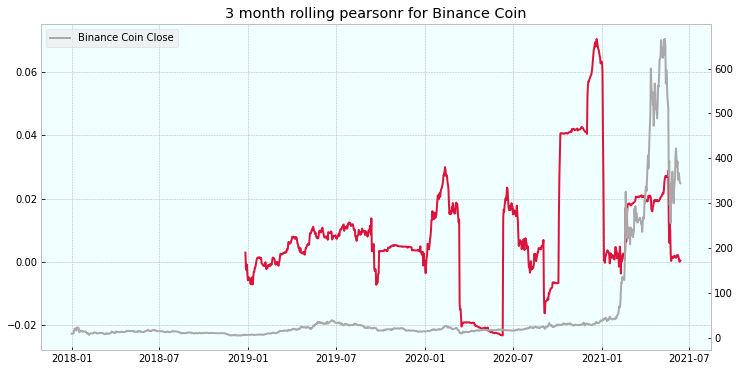

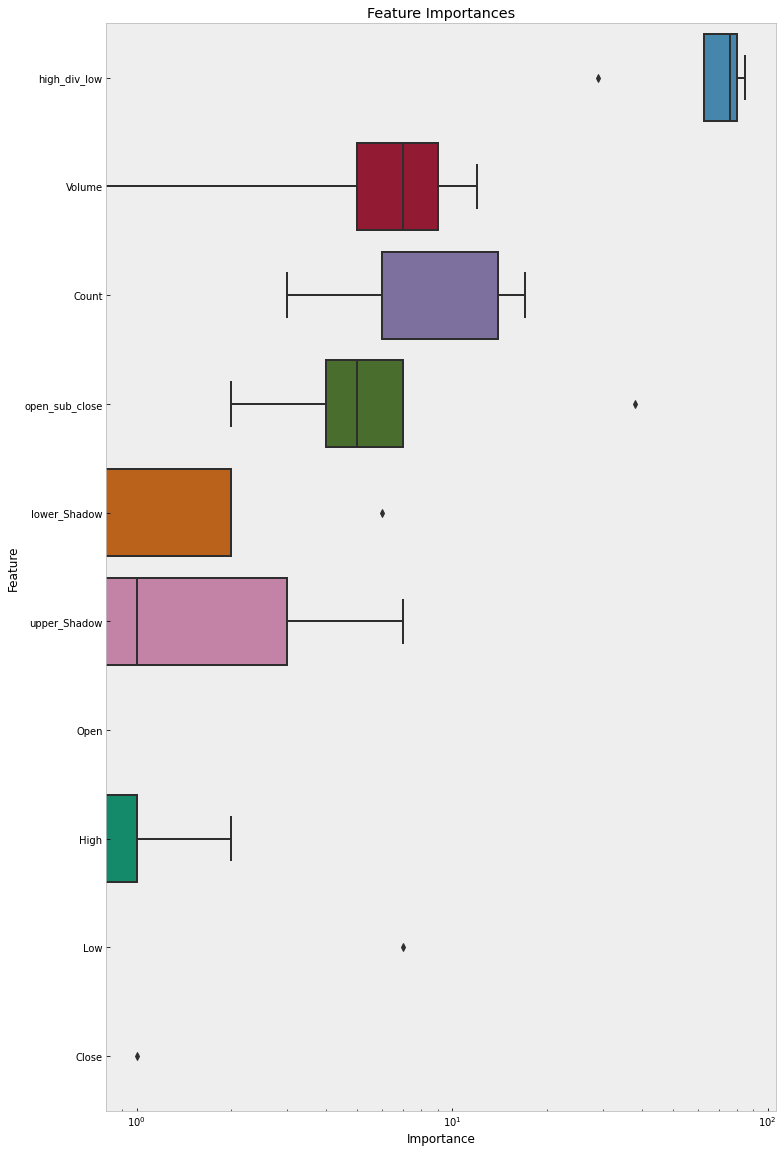



--------------------------------------------------------------------------------
Finished training EOS.IO. Results:
Model: r2_score: -0.0002633781238379207 | pearsonr: -0.0043154325190736895 | wcorr: -0.004315432519073691 
Predictions std: 6.015196461444283e-05 | Target std: 0.00494493082502521


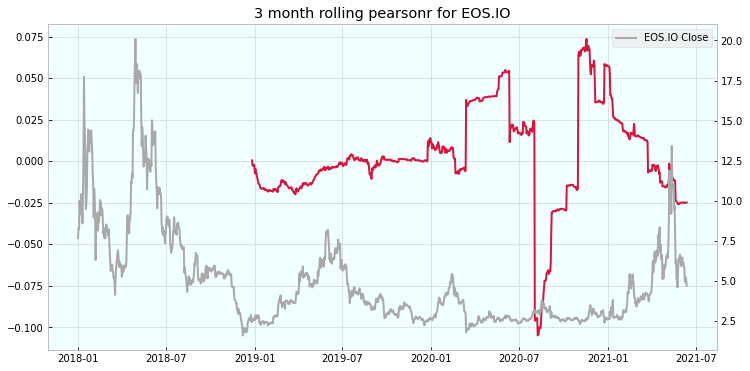

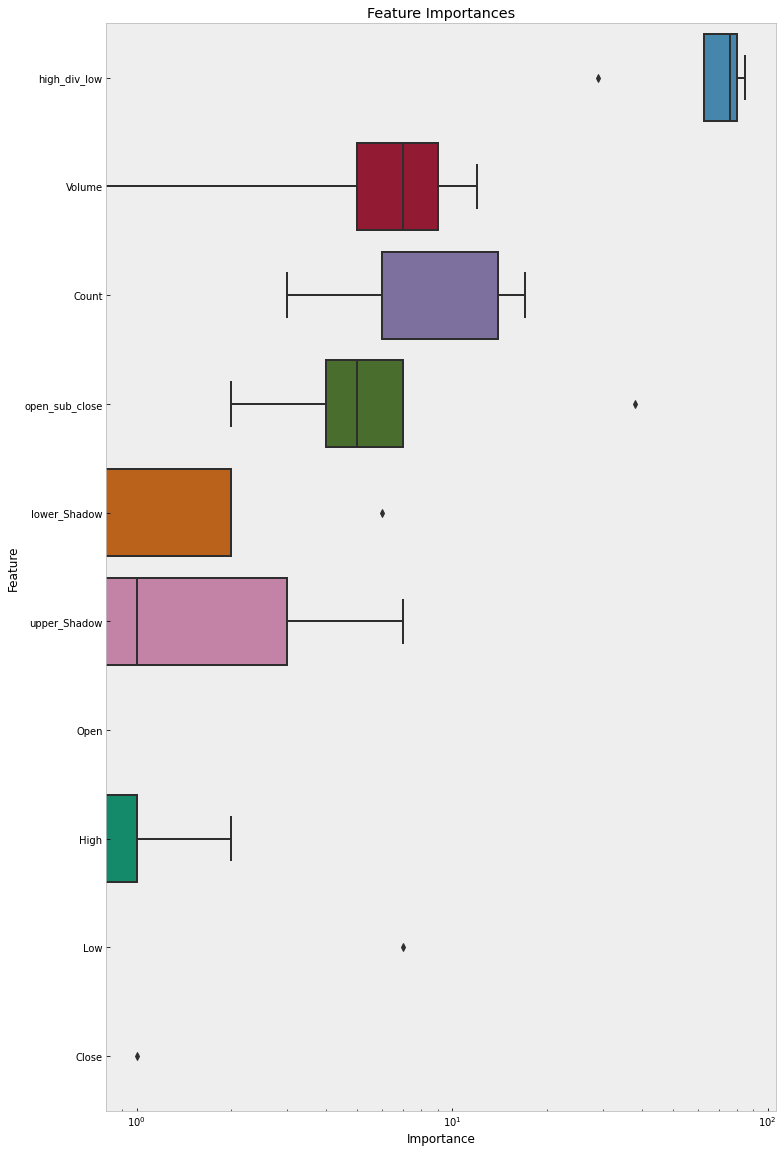



--------------------------------------------------------------------------------
Finished training Monero. Results:
Model: r2_score: -7.232891042119327e-05 | pearsonr: 0.0012349247248946583 | wcorr: 0.001234924724894943 
Predictions std: 6.086411399163226e-05 | Target std: 0.00633161487502712


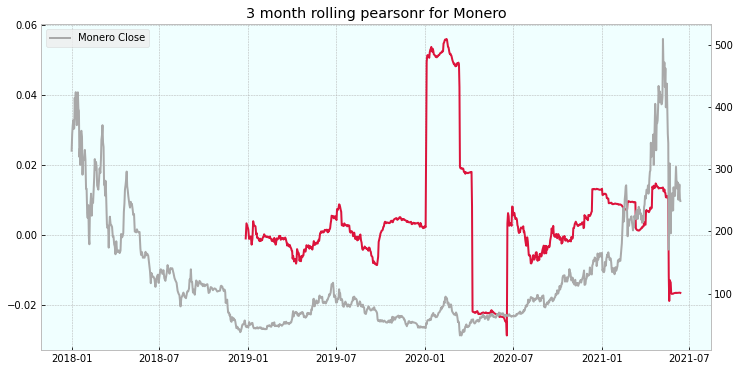

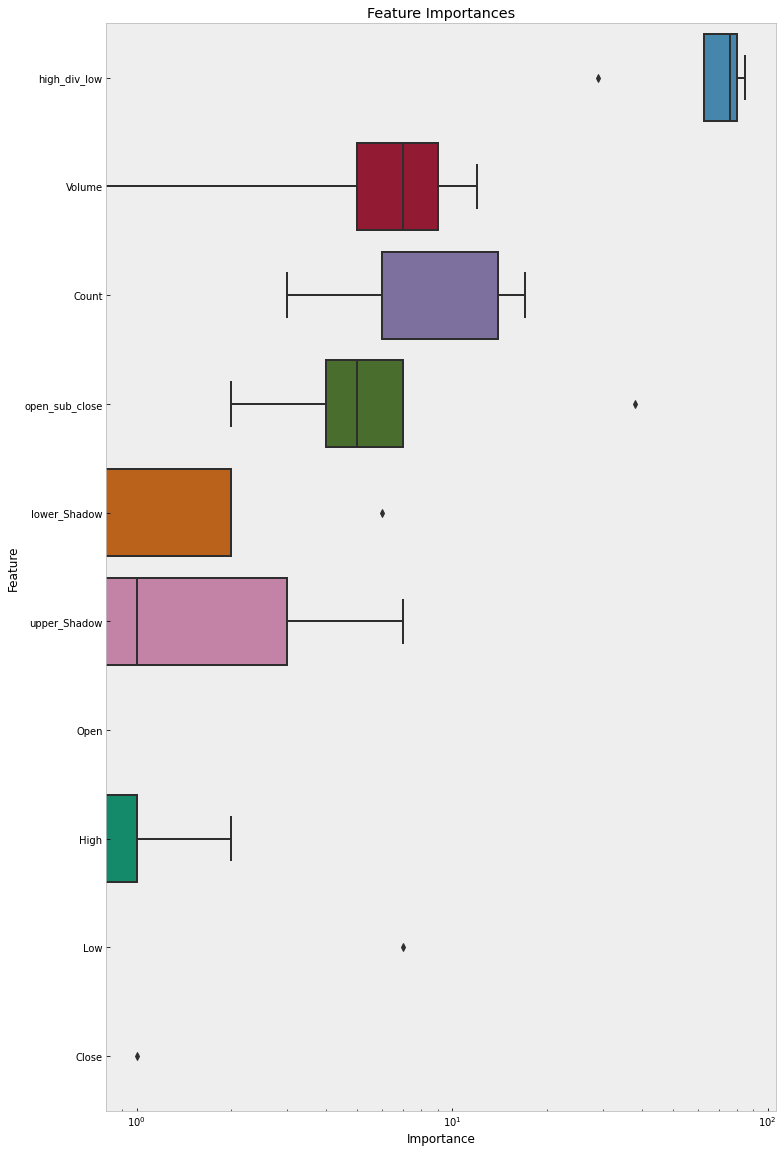



--------------------------------------------------------------------------------
Finished training Ethereum. Results:
Model: r2_score: -0.000817149924756233 | pearsonr: -0.00012759487066601864 | wcorr: -0.00012759487066597635 
Predictions std: 7.008720297598969e-05 | Target std: 0.002542099215310343


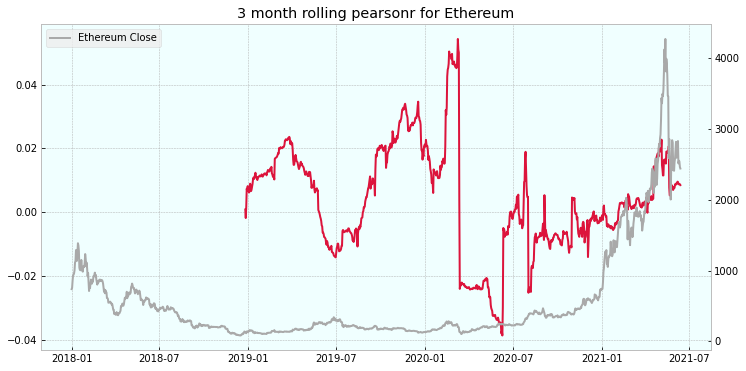

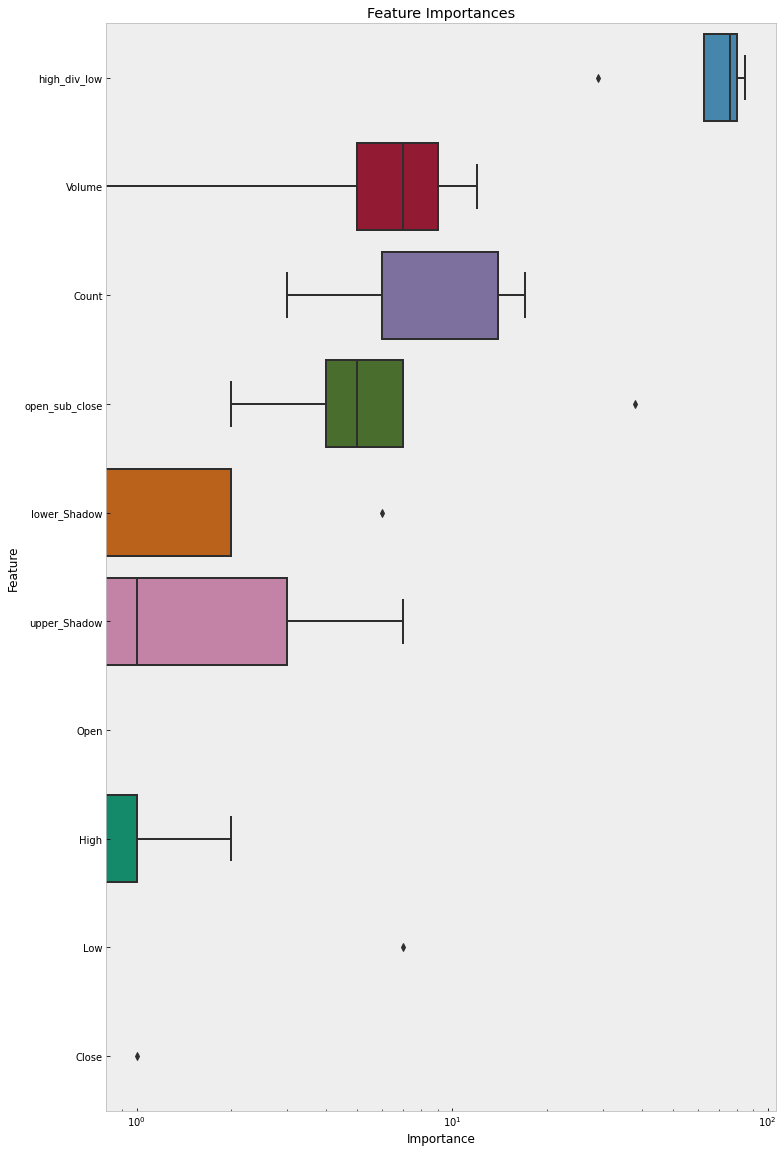



--------------------------------------------------------------------------------
Finished training Ethereum Classic. Results:
Model: r2_score: -0.009159675834374381 | pearsonr: 0.0056670598948744145 | wcorr: 0.005667059894874433 
Predictions std: 0.0009238771270089575 | Target std: 0.009254690541410452


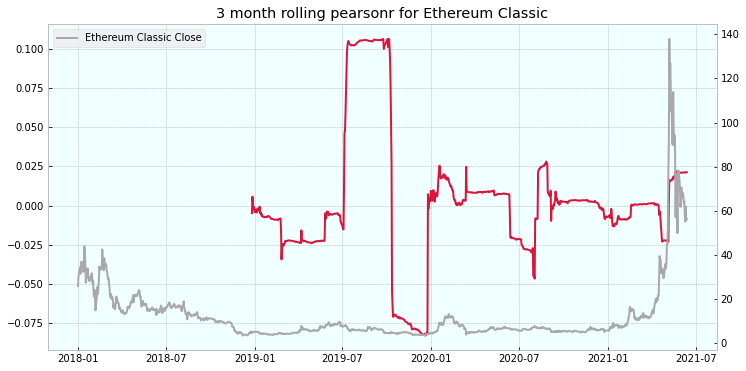

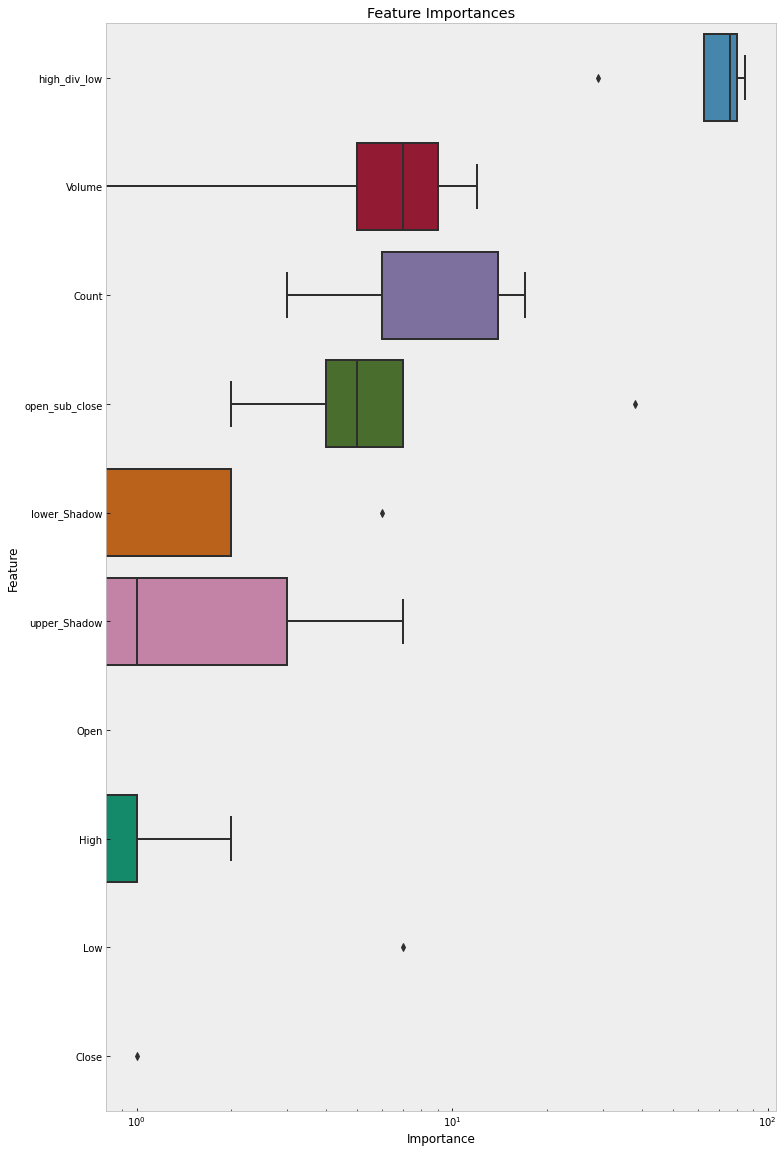



--------------------------------------------------------------------------------
Finished training Litecoin. Results:
Model: r2_score: -0.0003286605412275989 | pearsonr: -0.0011407234092834949 | wcorr: -0.0011407234092835157 
Predictions std: 5.960468925177116e-05 | Target std: 0.003591519223735473


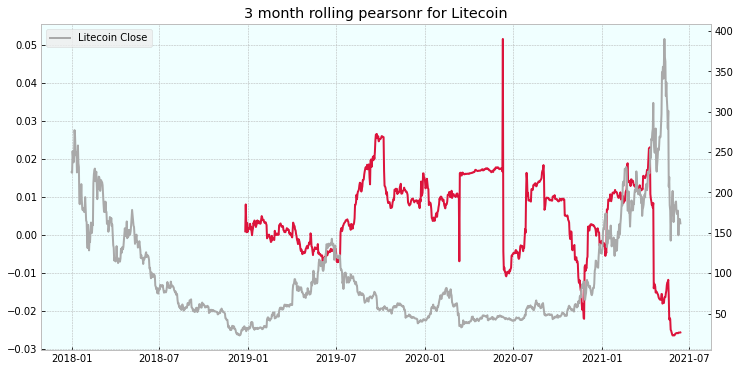

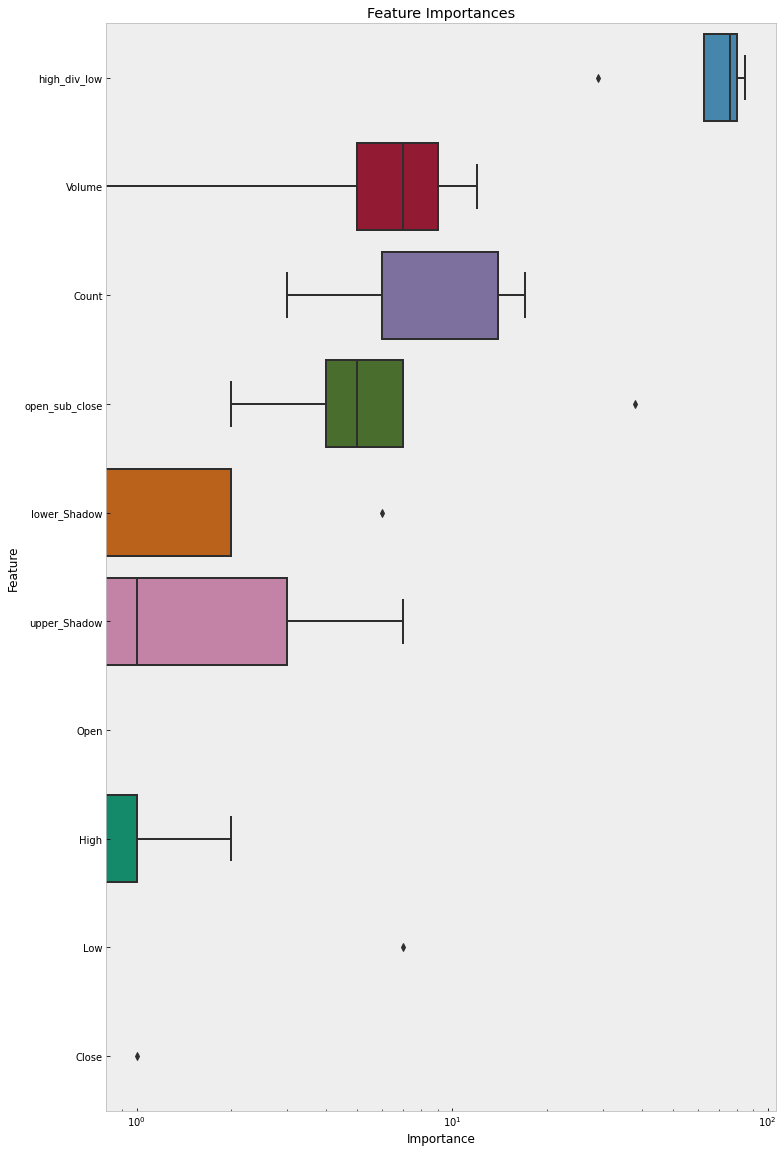



--------------------------------------------------------------------------------
Finished training Bitcoin Cash. Results:
Model: r2_score: 4.908273900994242e-05 | pearsonr: 0.008677565798274115 | wcorr: 0.008677565798274127 
Predictions std: 9.236507831237454e-05 | Target std: 0.006694166208082861


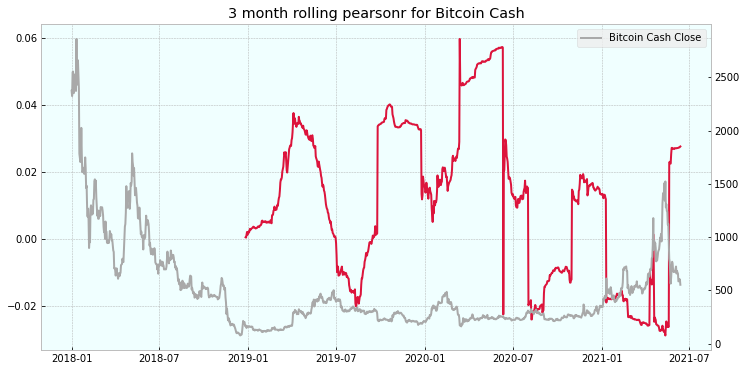

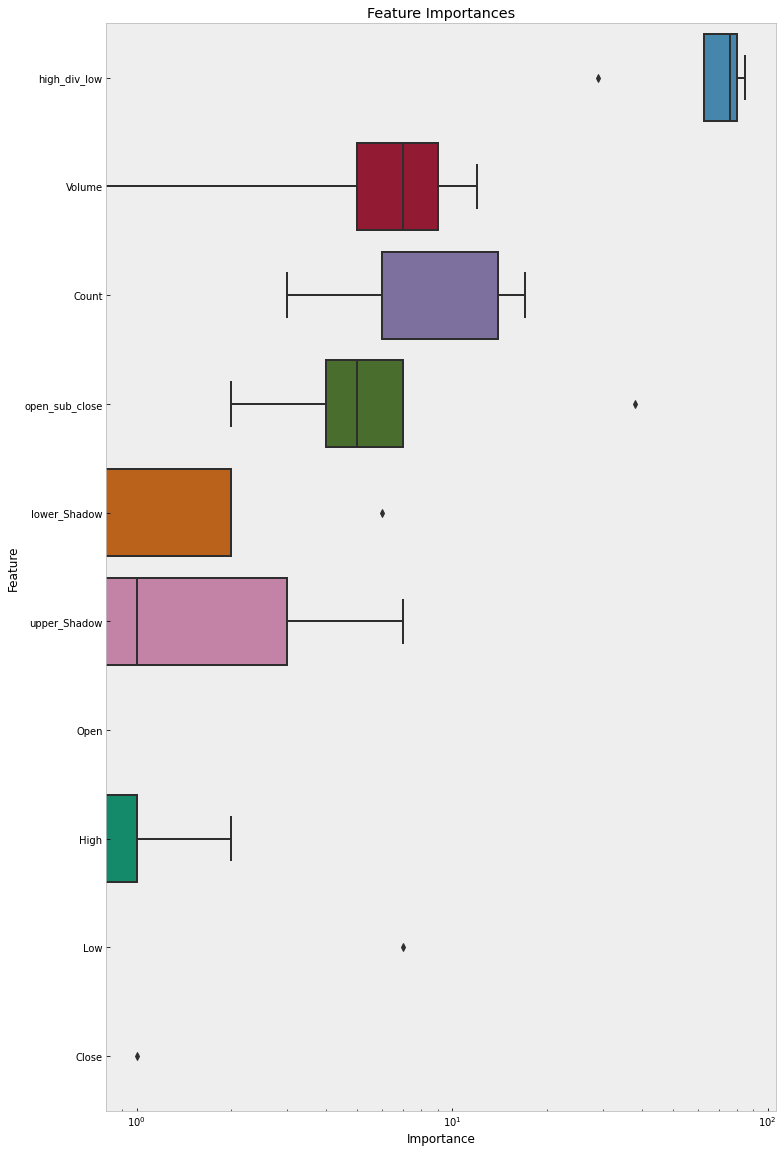



--------------------------------------------------------------------------------
Finished training Bitcoin. Results:
Model: r2_score: -0.0029141301344275394 | pearsonr: -0.004935016979312347 | wcorr: -0.004935016979312336 
Predictions std: 9.315802180960598e-05 | Target std: 0.002043465367662073


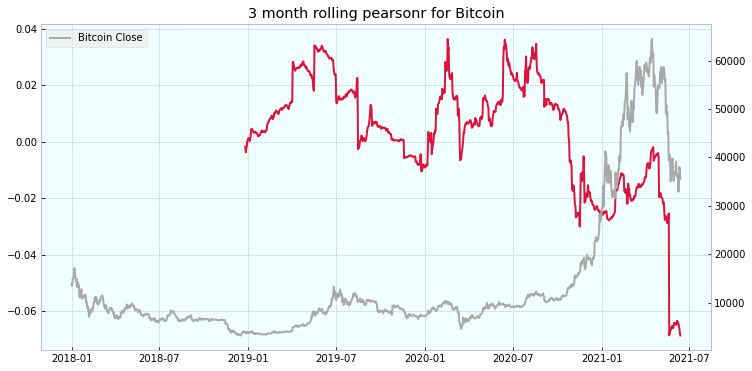

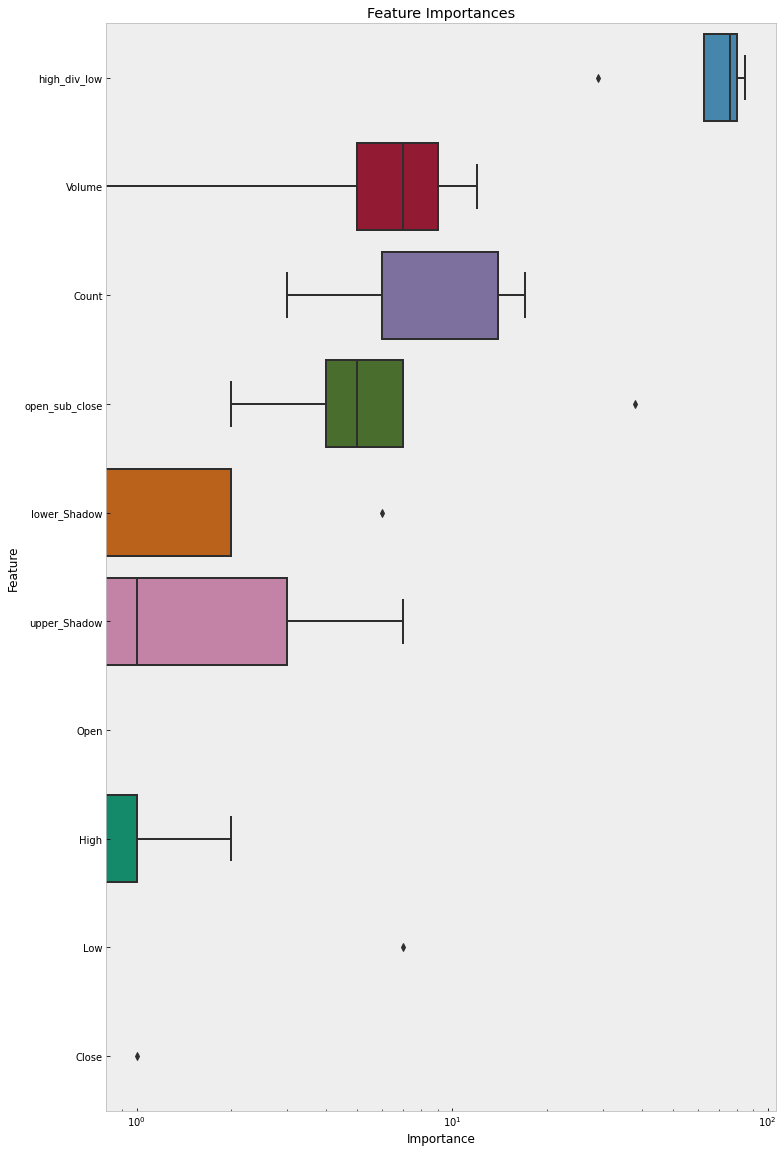



--------------------------------------------------------------------------------
Finished training TRON. Results:
Model: r2_score: -0.0004588988853888587 | pearsonr: -0.004026656786646228 | wcorr: -0.004026656786646227 
Predictions std: 8.767409971493608e-05 | Target std: 0.005027229997011936


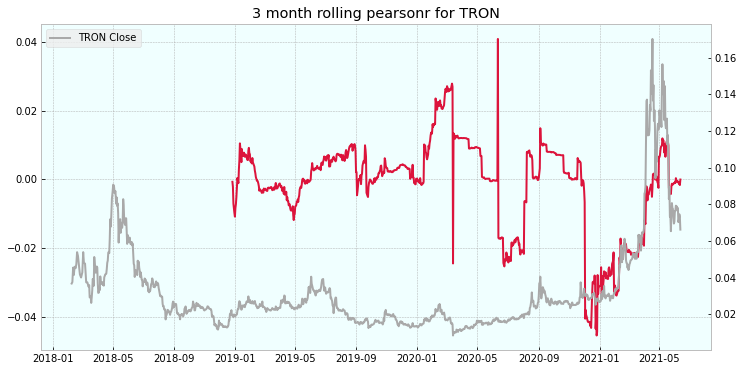

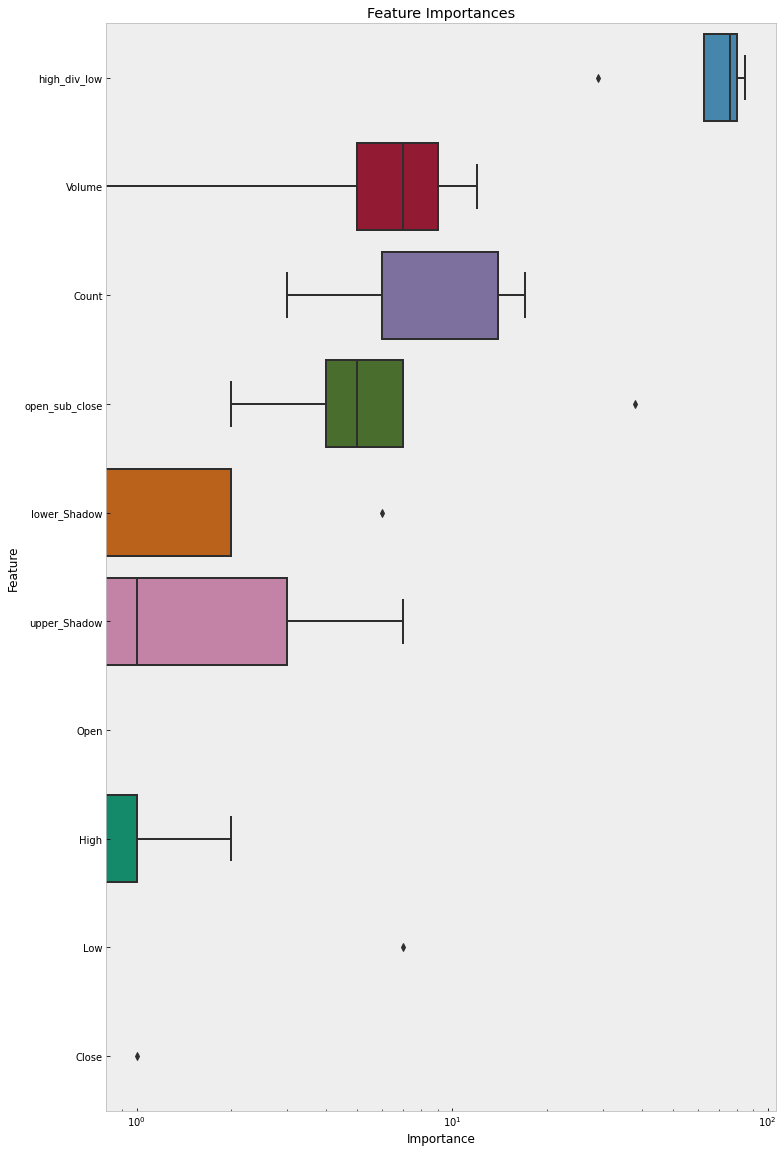



--------------------------------------------------------------------------------
Finished training Stellar. Results:
Model: r2_score: 0.0002549751965628122 | pearsonr: 0.016297699335901816 | wcorr: 0.0162976993359018 
Predictions std: 9.152359533359241e-05 | Target std: 0.005264874907634628


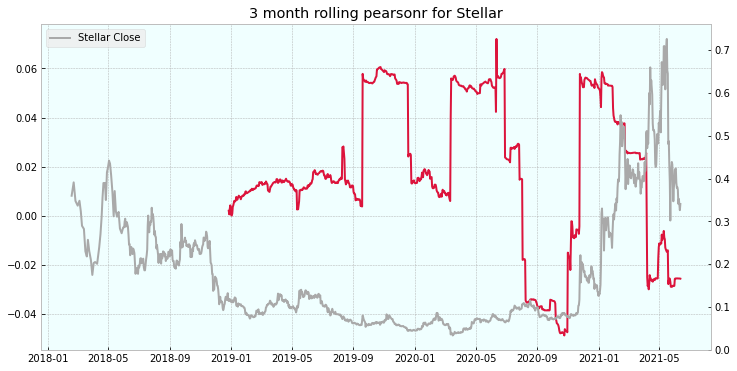

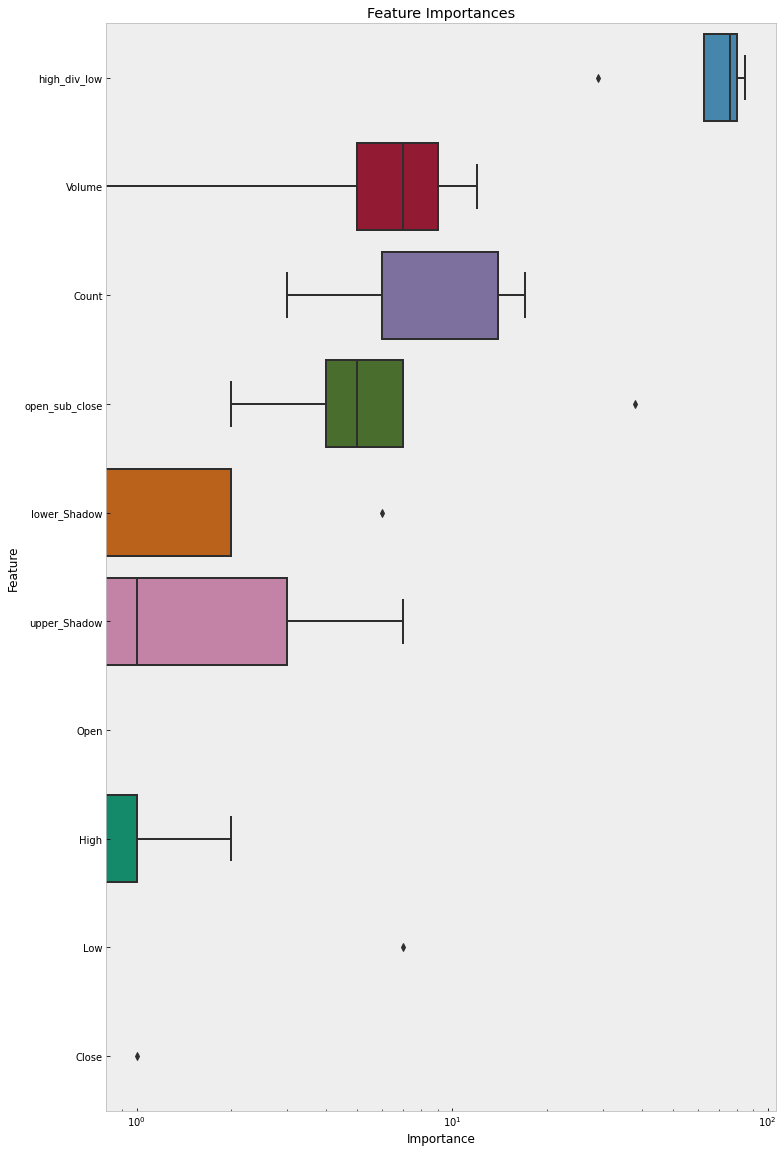



--------------------------------------------------------------------------------
Finished training Cardano. Results:
Model: r2_score: 0.00018300881782173928 | pearsonr: 0.01405015662149195 | wcorr: 0.01405015662149191 
Predictions std: 7.79490327153947e-05 | Target std: 0.004592266495116166


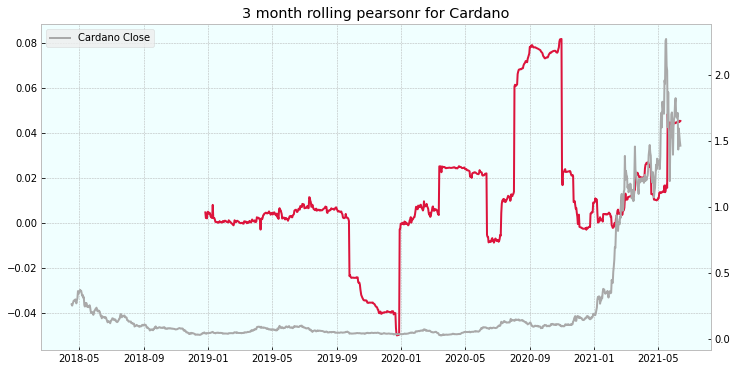

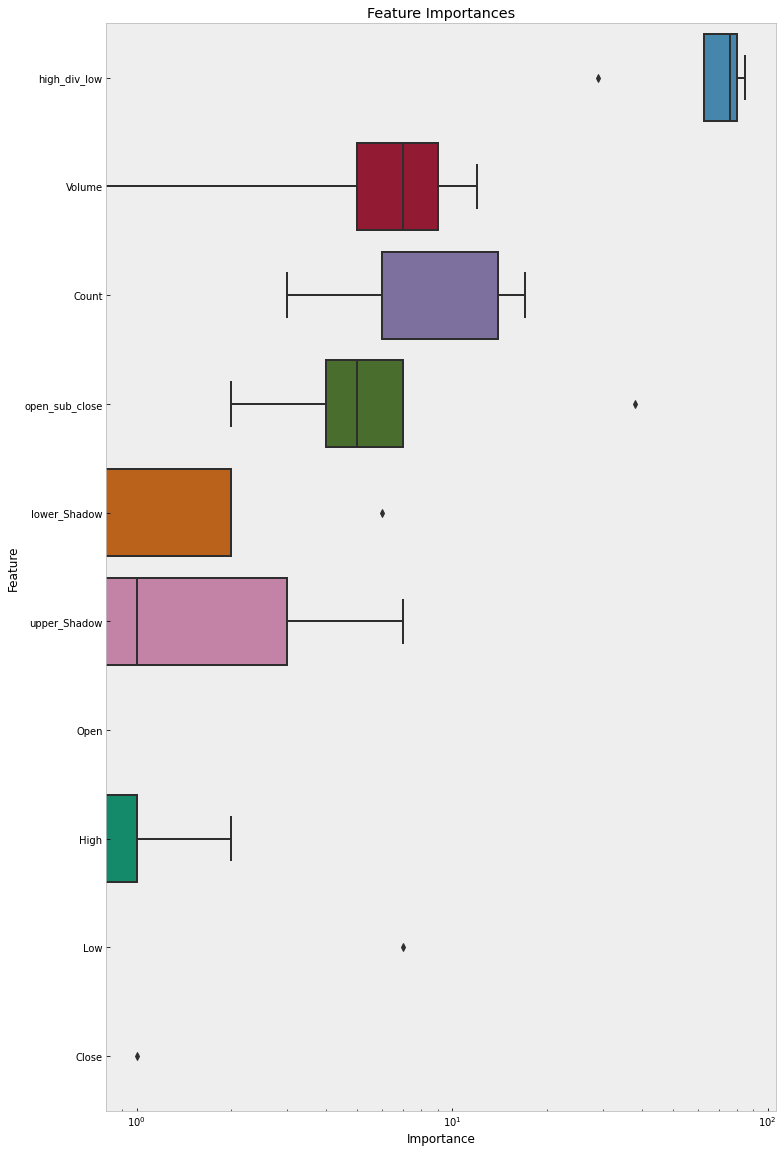



--------------------------------------------------------------------------------
Finished training IOTA. Results:
Model: r2_score: -0.0023393462459586623 | pearsonr: -0.005353735763540161 | wcorr: -0.005353735763540137 
Predictions std: 0.00030224291994998705 | Target std: 0.00699462328939879


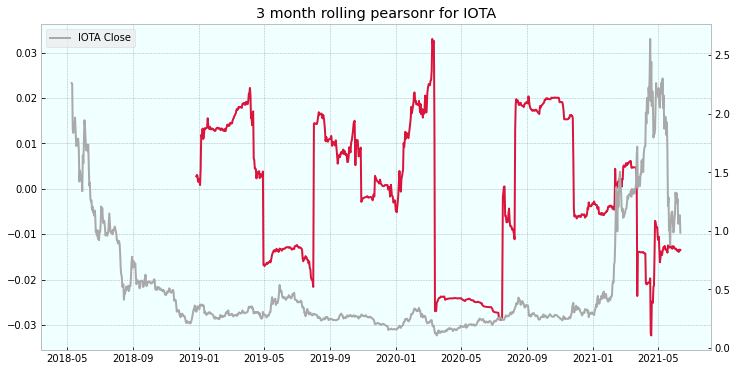

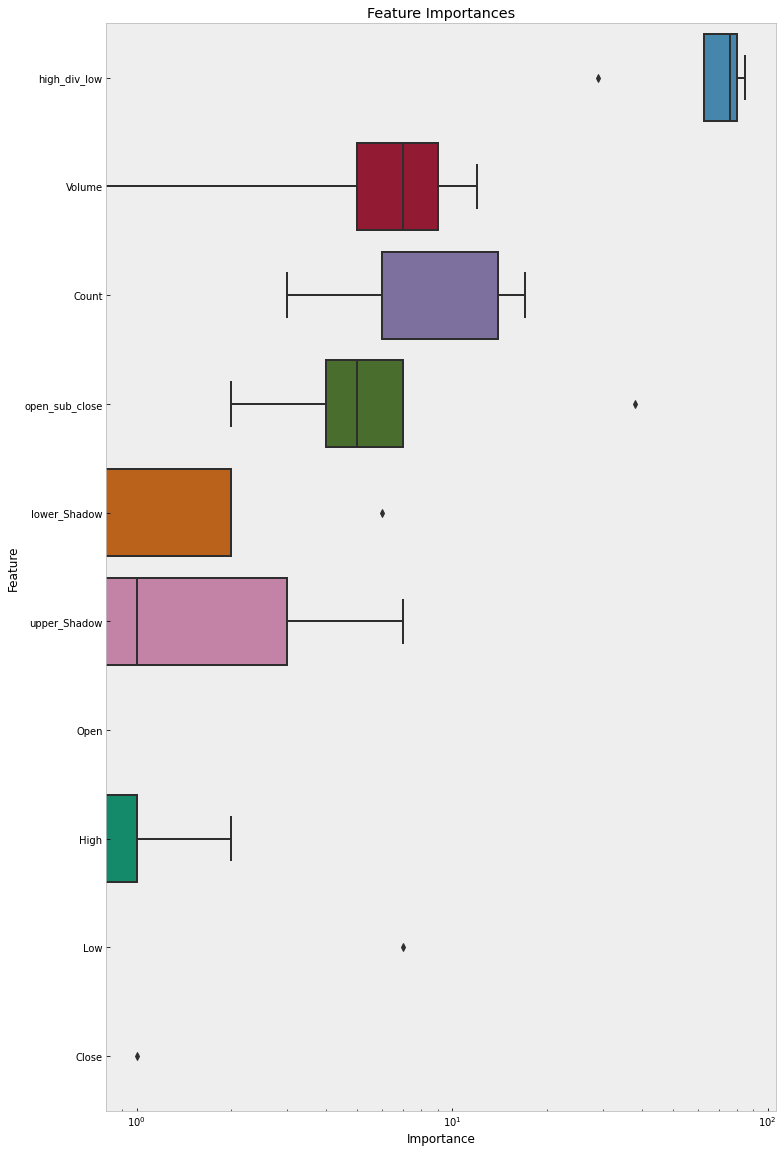



--------------------------------------------------------------------------------
Finished training Maker. Results:
Model: r2_score: -0.0002507254771166867 | pearsonr: -0.0026408179800713107 | wcorr: -0.0026408179800711863 
Predictions std: 7.999854712856685e-05 | Target std: 0.005966691452771564


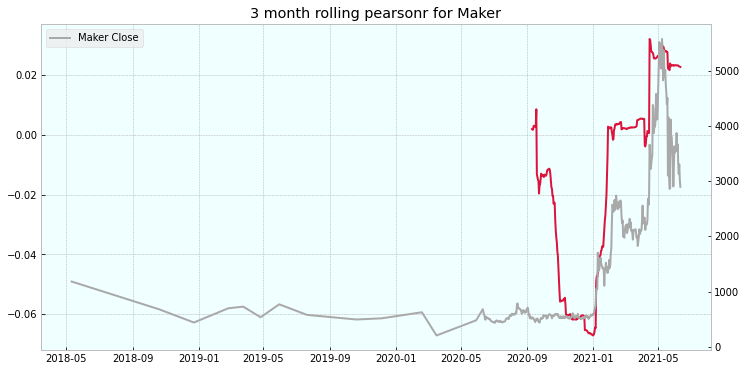

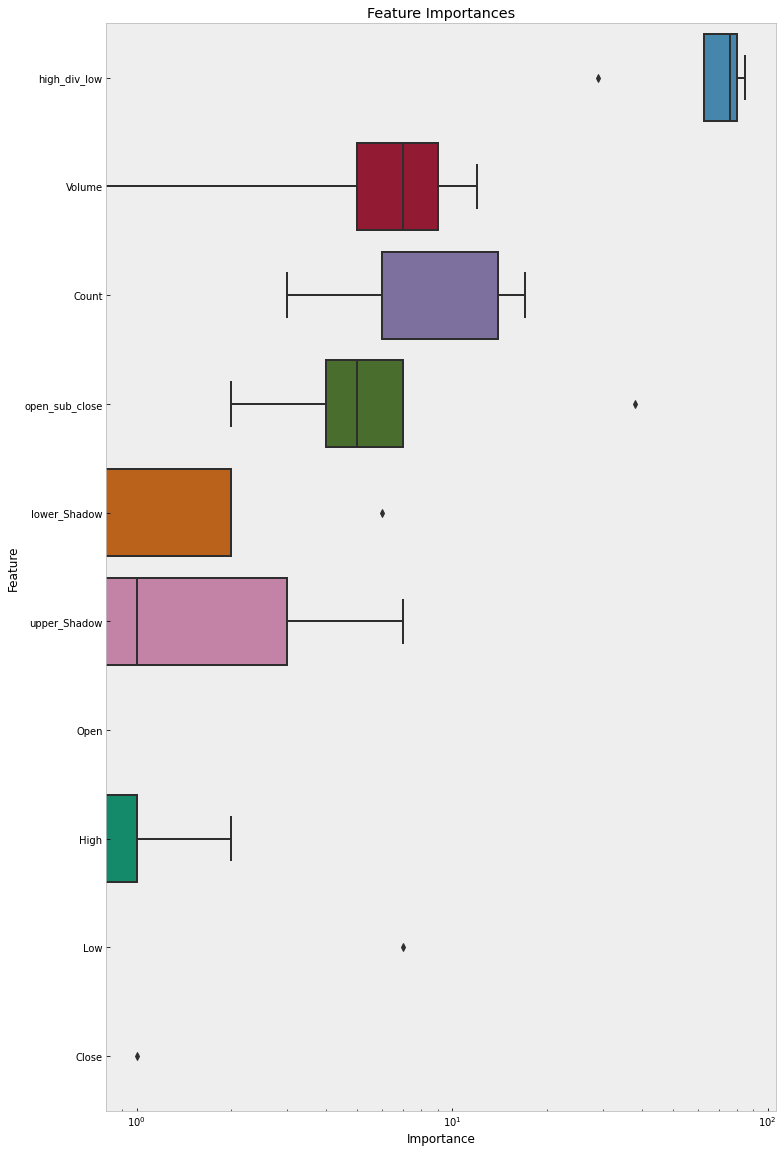



--------------------------------------------------------------------------------
Finished training Dogecoin. Results:
Model: r2_score: 0.0005195103945426771 | pearsonr: 0.023464163464515027 | wcorr: 0.02346416346451491 
Predictions std: 0.0001430153847396595 | Target std: 0.007992163440899341


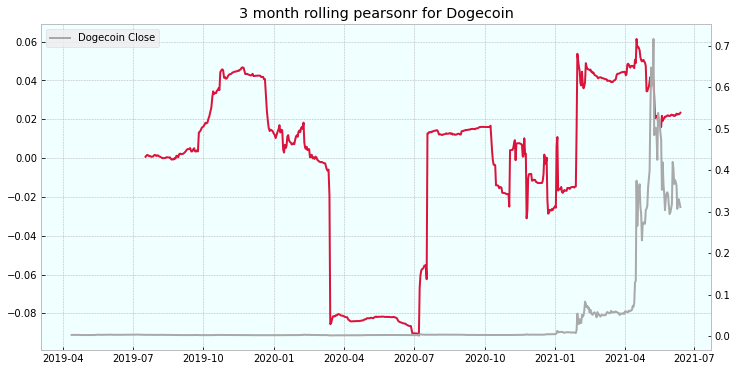

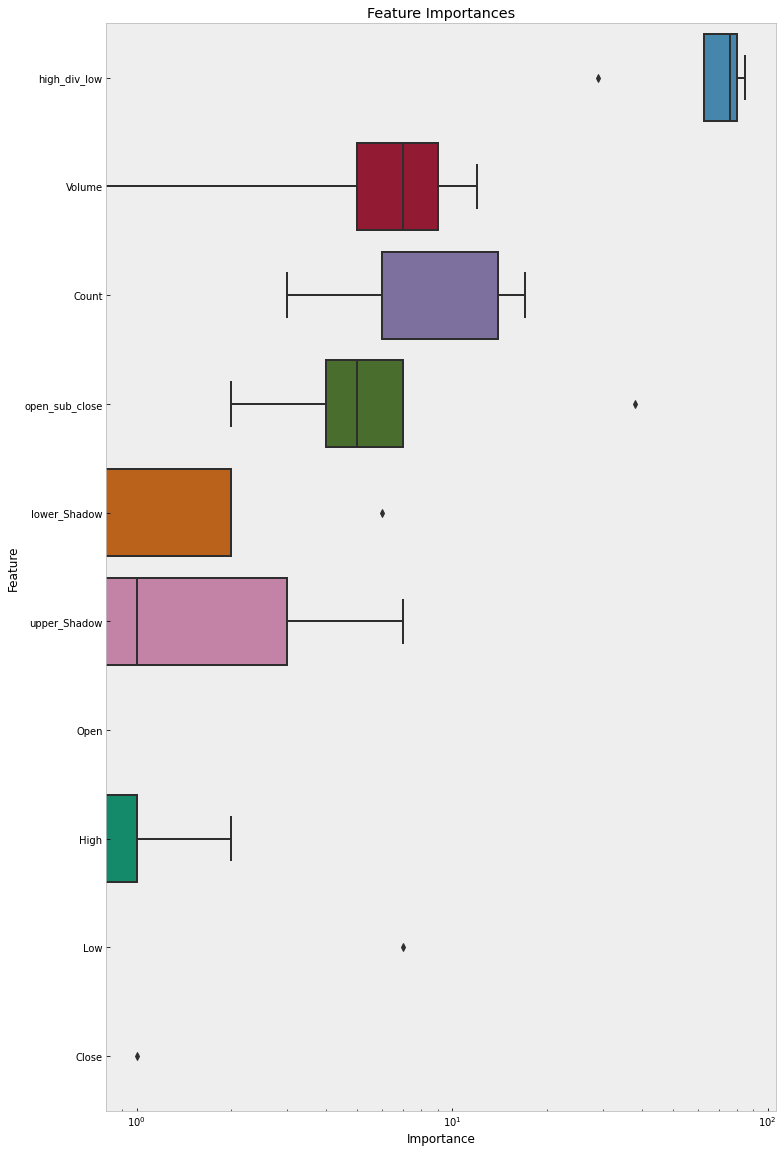

77107

In [20]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from matplotlib.colors import ListedColormap

def plot_importance(importances, features_names, PLOT_TOP_N = 20, figsize=(12, 20)):
    try: plt.close()
    except: pass
    importance_df = pd.DataFrame(data=importances, columns=features_names)
    sorted_indices = importance_df.median(axis=0).sort_values(ascending=False).index
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    plot_cols = sorted_importance_df.columns[:PLOT_TOP_N]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    plt.title('Feature Importances')
    sns.boxplot(data=sorted_importance_df[plot_cols], orient='h', ax=ax)
    plt.show()
    
    
pd.DataFrame({'timestamp': train_data['timestamp'], 'asset_id': train_data['Asset_ID'], 'oof_preds': oof}).to_csv('oof.csv', index = False)

for asset in train_data['Asset_ID'].unique().tolist():       
    df = train_data.loc[train_data['Asset_ID'] == asset]
    df['oof_preds'] = np.nan_to_num(oof[train_data['Asset_ID'] == asset])
    df['Target'] = np.nan_to_num(df['Target'])
    df['y'] = np.nan_to_num(df['Target'])
    
    print('\n\n' + ('-' * 80) + '\n' + 'Finished training %s. Results:' % asset_name_dict[asset])
    print('Model: r2_score: %s | pearsonr: %s | wcorr: %s ' % (r2_score(df['y'], df['oof_preds']), pearsonr(df['y'], df['oof_preds'])[0], corr(df['y'].values, df['oof_preds'].values, np.array([asset_weight_dict[asset_id]] * len(df['y'].values)))))
    print('Predictions std: %s | Target std: %s' % (df['oof_preds'].std(), df['y'].std()))
    
    try: plt.close()
    except: pass   
    df2 = df.reset_index().set_index('date')
    fig = plt.figure(figsize = (12, 6))
    # fig, ax_left = plt.subplots(figsize = (12, 6))
    ax_left = fig.add_subplot(111)
    ax_left.set_facecolor('azure')    
    ax_right = ax_left.twinx()
    ax_left.plot(df2['y'].rolling(3 * 30 * 24 * 60).corr(df2['oof_preds']).iloc[::24 * 60], color = 'crimson', label = "Target WCorr")
    ax_right.plot(df2['Close'].iloc[::24 * 60], color = 'darkgrey', label = "%s Close" % asset_name_dict[asset])   
    plt.legend()
    plt.grid()
    plt.xlabel('Time')
    plt.title('3 month rolling pearsonr for %s' % (asset_name_dict[asset]))
    plt.show()
    
    plot_importance(np.array(importances), feature_names, PLOT_TOP_N = 20)
    
gc.collect()

# <span class="title-section w3-xxlarge" id="submit">Submit To Kaggle 🇰</span>
<hr>

Prediction is a simple loop calling the `predict` method on `pipe`. Note that the mean imputation and scaling is done automatically.

In [21]:
env = gresearch_crypto.make_env()
iter_test = env.iter_test()

In [22]:
all_df_test = []
for i, (df_test, df_pred) in enumerate(iter_test):
    for j , row in df_test.iterrows():
        try:            
            x_test = get_features(row)
            x_test = fill_nan_inf(x_test)
            y_pred = np.mean(np.concatenate([np.expand_dims(model.predict([x_test[feature_names].values]), axis = 0) for model in models], axis = 0), axis = 0)
        except: 
            y_pred = 0.0
            traceback.print_exc()
        df_pred.loc[df_pred['row_id'] == row['row_id'], 'Target'] = y_pred
    all_df_test.append(df_test)
    env.predict(df_pred)

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
